In [1]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
import tensorflow as tf
#from tensorflow.python.keras.optimizer_v2 import adam_v2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
import cv2
import pandas as pd
import os
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

with_mask: 10000
<class 'list'>


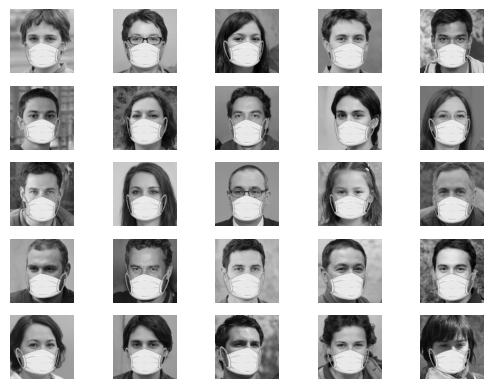

In [2]:
with_mask='/kaggle/input/facemask-detection-dataset-20000-images/new_with_mask'
#print(os.listdir(without_mask))
print("with_mask:",len(os.listdir(with_mask)))

data=[]
for img in os.listdir(with_mask):
    img_arr=cv2.imread(os.path.join(with_mask,img))
    data.append(img_arr)
print(type(data))    
trainX = data[0:5000] #Memory problem

# plot 25 images
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(trainX[i])
plt.show()


In [3]:
print(len(trainX))
for i in range (10):
    print(trainX[i].shape)

6000
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [4]:
def define_discriminator(in_shape=(224,224,3)):
    model = Sequential()

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten()) #shape of 8192
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) #shape of 1
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [5]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
    model = Sequential()
    # We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    n_nodes = 128 * 56 * 56  #8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((56, 56, 128)))  #8x8x128 dataset from the latent vector. 
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model.
    print(test_gen.summary())

In [6]:
def define_gan(generator, discriminator):
    discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
    # connect generator and discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [7]:
def load_real_samples():
    # cConvert to float and scale.
    #X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X= np.array(trainX, dtype=np.float32)
    X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
    return X

In [8]:
def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    #print('ix',ix)
    #print(dataset.shape[0])
    # select the random images and assign it to X
    X = dataset[ix]
    # generate class labels and assign to y
    y = ones((n_samples, 1)) ##Label=1 indicating they are real
    return X, y


In [9]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [10]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict using generator to generate fake samples. 
    X = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake. 
    y = zeros((n_samples, 1))  #Label=0 indicating they are fake
    return X, y

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
    print('len of data',len(dataset))
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
    # manually enumerate epochs and bacthes. 
    for i in range(n_epochs):
        #print('i',i)
# enumerate batches over the training set
        for j in range(bat_per_epo):
            #print('j',j)
            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            #print(len(X_real))
            #print(len(y_real))
            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
            #print('d_loss_real',d_loss_real)
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            #print(len(X_fake))
            #print(len(y_fake))
            # update discriminator model weights
            
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            #print('d_loss_fake',d_loss_fake)
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            #print('x_gan',len(X_gan))
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)			
            y_gan = ones((n_batch, 1))
            #print('y_gan',len(y_gan))
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            #print('g_loss',g_loss)
            # Print losses on this batch
            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
            g_model.save('cifar_generator_2epochs.h5')

In [12]:
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


len of data 6000
1/1 [==============================] - 2s 2s/step
Epoch>1, Batch 1/93, d1=0.710, d2=0.698 g=0.693
1/1 [==============================] - 0s 20ms/step
Epoch>1, Batch 2/93, d1=0.042, d2=0.700 g=0.696
1/1 [==============================] - 0s 18ms/step
Epoch>1, Batch 3/93, d1=0.010, d2=0.699 g=0.705
1/1 [==============================] - 0s 20ms/step
Epoch>1, Batch 4/93, d1=0.005, d2=0.689 g=0.730
1/1 [==============================] - 0s 20ms/step
Epoch>1, Batch 5/93, d1=0.003, d2=0.656 g=0.793
1/1 [==============================] - 0s 21ms/step
Epoch>1, Batch 6/93, d1=0.003, d2=0.601 g=0.883
1/1 [==============================] - 0s 18ms/step
Epoch>1, Batch 7/93, d1=0.007, d2=0.550 g=0.979
1/1 [==============================] - 0s 18ms/step
Epoch>1, Batch 8/93, d1=0.013, d2=0.504 g=1.062
1/1 [==============================] - 0s 21ms/step
Epoch>1, Batch 9/93, d1=0.007, d2=0.448 g=1.201
1/1 [==============================] - 0s 19ms/step
Epoch>1, Batch 10/93, d1=0.013, d

1/1 [==============================] - 2s 2s/step


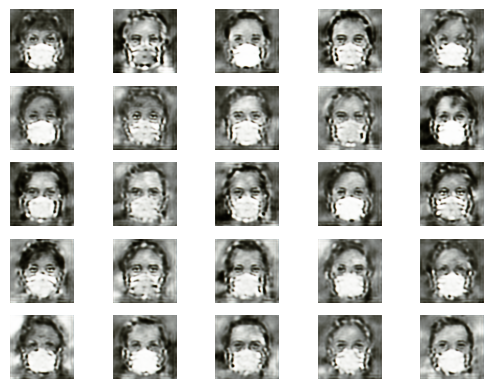

In [13]:
from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model('/kaggle/working/cifar_generator_2epochs.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck
